# Project 22 - medical image captioning - VQA-Med-2019

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
path_to_src = os.path.join(os.path.abspath(''), os.pardir, 'src')
path_to_data = os.path.join(os.path.abspath(''), os.pardir, 'data')
sys.path.append(path_to_src)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import spacy

%matplotlib inline

In [4]:
SPEEDUP_SAMPLE_SIZE = None # Use None if you want to use full dataset and int for random sample size to speed up the analysis (does not use all the data then)  

## Data loading

In [5]:
def read_qa_dataframe(path):
    data = pd.read_csv(path, sep="|", header=None)
    data.columns = ["image_id", "question", "answer"]
    return data


def read_qa_by_category(path_to_category_files):
    files = os.listdir(path_to_category_files)
    dfs = []
    for file in files:
        if file.startswith("C") and file.endswith("_train.txt"):
            category = file.split("_")[1].lower()
            category_df = read_qa_dataframe(os.path.join(path_to_category_files, file))
            category_df["category"] = category
            dfs.append(category_df)
    return pd.concat(dfs)

In [6]:
df = read_qa_by_category(os.path.join(path_to_data, "ImageClef-2019-VQA-Med-Training/QAPairsByCategory"))

In [7]:
df.head()

,image_id,question,answer,category
0,synpic41148,what kind of image is this?,cta - ct angiography,modality
1,synpic43984,is this a t1 weighted image?,no,modality
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,modality
3,synpic52143,is this a noncontrast mri?,no,modality
4,synpic20934,what type of image modality is this?,xr - plain film,modality


## Visualize Q/A pairs with images

In [8]:
categories = df['category'].unique()

sampled_dfs = []
for idx, category in enumerate(categories):
    filtered_df = df.loc[df['category'] == category]
    sampled_dfs.append(filtered_df.sample(4, random_state=10 + idx))
visualization_df = pd.concat(sampled_dfs)

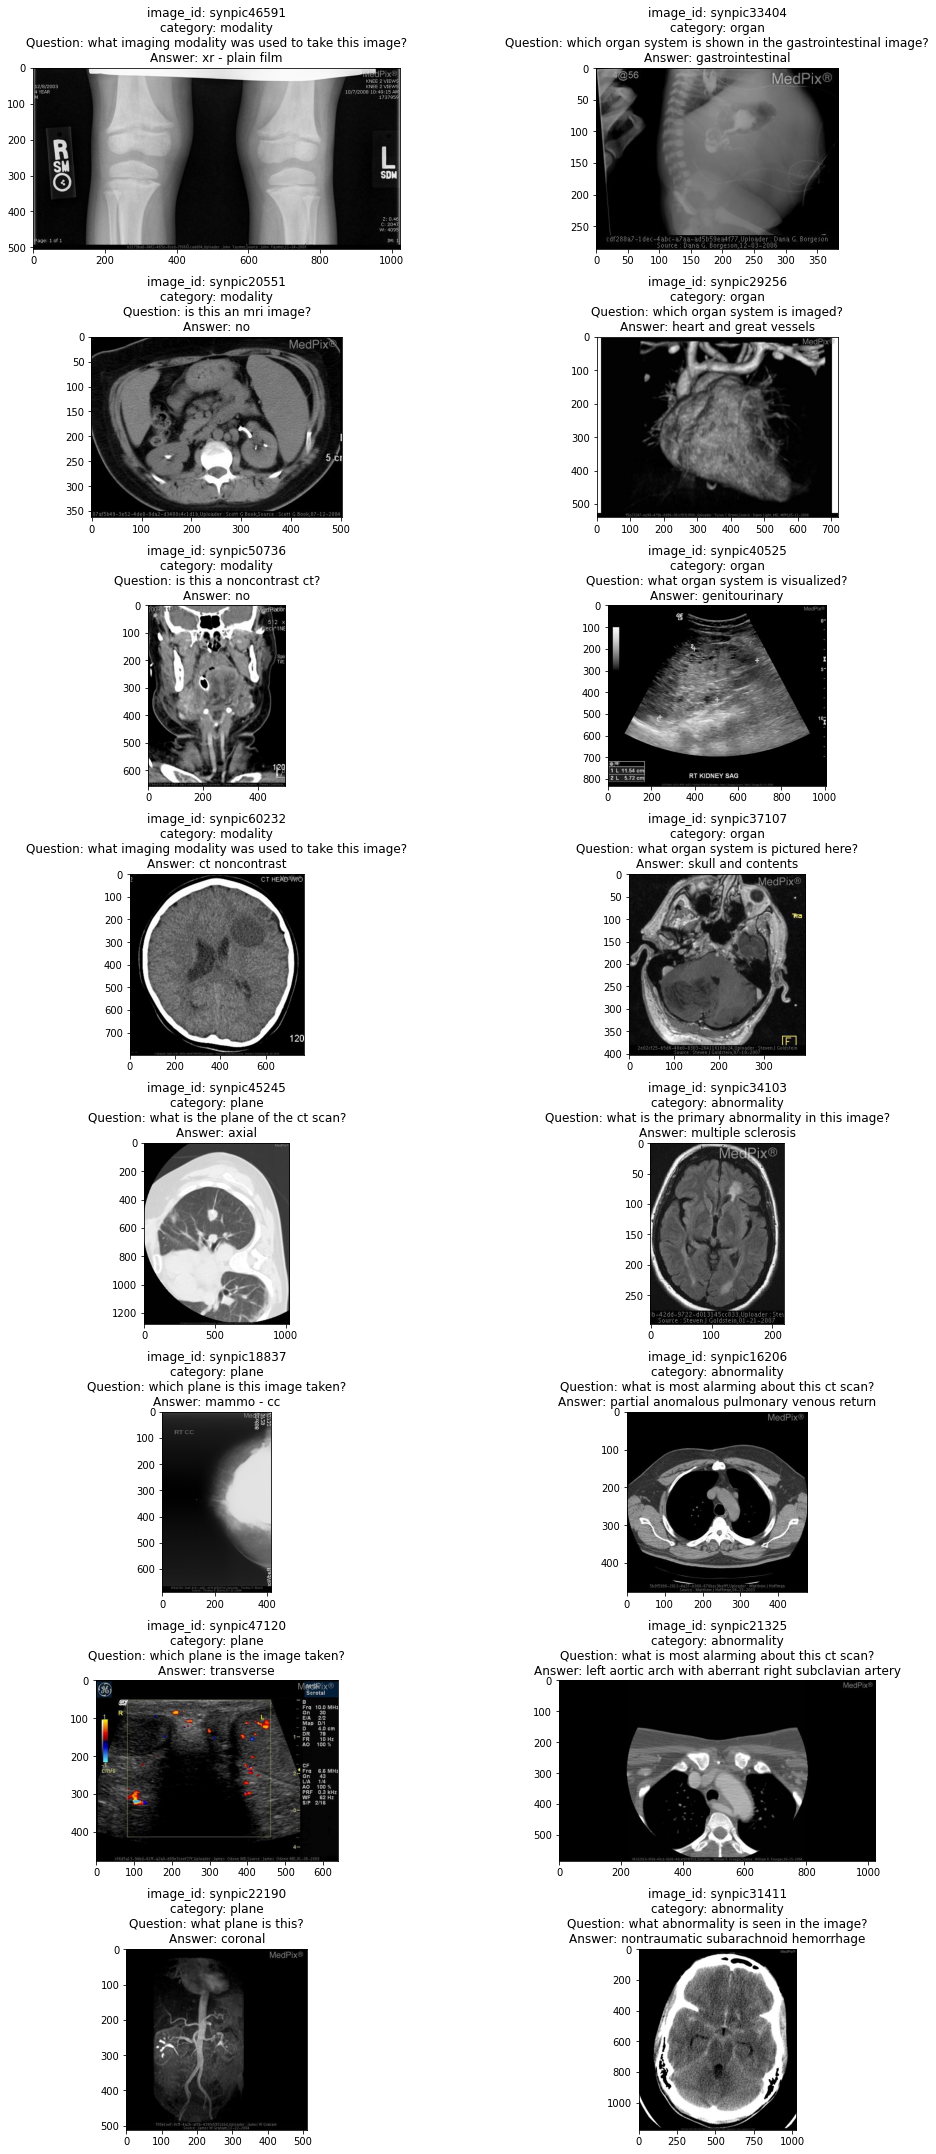

In [9]:
rcParams['figure.figsize'] = 15 , 30

IMG_ROWS = 8
IMG_COLS = 2
fig, ax = plt.subplots(IMG_ROWS, IMG_COLS)

img_idx = 0
for index, row in visualization_df.iterrows():
    image_id = row['image_id']
    img = mpimg.imread(os.path.join(path_to_data, f"ImageClef-2019-VQA-Med-Training/Train_images/{image_id}.jpg"))
    axi = ax[img_idx % IMG_ROWS][img_idx // IMG_ROWS]
    axi.imshow(img);
    axi.title.set_text(f"image_id: {image_id}\ncategory: {row['category']}\nQuestion: {row['question']}\nAnswer: {row['answer']}")
    img_idx += 1
fig.tight_layout(pad=1.0)

## Tokenize

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
# Sample to save time on processing when hacking around (actual analysis will be done with full dataframe)
if SPEEDUP_SAMPLE_SIZE is not None:
    df = df.sample(SPEEDUP_SAMPLE_SIZE, random_state=42)

In [12]:
def spacy_tokenize(text, lower=True):
    return nlp(text.lower() if lower else text)

In [13]:
df['question_spacy_tokens'] = df['question'].apply(spacy_tokenize)
df['answer_spacy_tokens'] = df['answer'].apply(spacy_tokenize)

In [14]:
df.head()

,image_id,question,answer,category,question_spacy_tokens,answer_spacy_tokens
0,synpic41148,what kind of image is this?,cta - ct angiography,modality,"(what, kind, of, image, is, this, ?)","(cta, -, ct, angiography)"
1,synpic43984,is this a t1 weighted image?,no,modality,"(is, this, a, t1, weighted, image, ?)",(no)
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,modality,"(what, type, of, imaging, modality, is, used, ...","(us, -, ultrasound)"
3,synpic52143,is this a noncontrast mri?,no,modality,"(is, this, a, noncontrast, mri, ?)",(no)
4,synpic20934,what type of image modality is this?,xr - plain film,modality,"(what, type, of, image, modality, is, this, ?)","(xr, -, plain, film)"


In [15]:
def string_tokenize(spacy_tokens, remove_stopwords=False, remove_punctuation=False, lemmatize=False):
    return [token.lemma_ if lemmatize else token.text 
            for token in spacy_tokens if 
            (not remove_stopwords or not token.is_stop)
           and (not remove_punctuation or not token.is_punct)]

# Not actually in use now
def filter_stopwords_and_punctuations(spacy_tokens):
    return [token for token in spacy_tokens if not token.is_stop and not token.is_punct]

# Not actually in use now
def lemmatizer(spacy_tokens):
    return [token.lemma_ for token in tokens]

In [16]:
def preprocess(df, remove_stopwords=False, remove_punctuation=False, lemmatize=False):
    fields = ['question', 'answer']
    for field in fields:
        df[f"{field}_string_tokens"] = df[f"{field}_spacy_tokens"].apply(lambda x: string_tokenize(x, remove_stopwords, remove_punctuation, lemmatize))

In [17]:
preprocess(df, True, True, True)

In [18]:
df.head(5)

,image_id,question,answer,category,question_spacy_tokens,answer_spacy_tokens,question_string_tokens,answer_string_tokens
0,synpic41148,what kind of image is this?,cta - ct angiography,modality,"(what, kind, of, image, is, this, ?)","(cta, -, ct, angiography)","[kind, image]","[cta, ct, angiography]"
1,synpic43984,is this a t1 weighted image?,no,modality,"(is, this, a, t1, weighted, image, ?)",(no),"[t1, weight, image]",[]
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,modality,"(what, type, of, imaging, modality, is, used, ...","(us, -, ultrasound)","[type, imaging, modality, acquire, image]",[ultrasound]
3,synpic52143,is this a noncontrast mri?,no,modality,"(is, this, a, noncontrast, mri, ?)",(no),"[noncontrast, mri]",[]
4,synpic20934,what type of image modality is this?,xr - plain film,modality,"(what, type, of, image, modality, is, this, ?)","(xr, -, plain, film)","[type, image, modality]","[xr, plain, film]"


## Token distributions

In [19]:
from collections import Counter

In [20]:
def get_token_counters(df):
    fields = ['question', 'answer']
    counters = {}
    for field in fields:
        counters[f"{field}_string_token_counter"] = Counter()

    for index, row in df.iterrows():
        for field in fields:
            for token in row[f"{field}_string_tokens"]:
                counters[f"{field}_string_token_counter"].update({token: 1})
    
    return counters

In [21]:
counters = get_token_counters(df)

In [22]:
most_common_count = 20

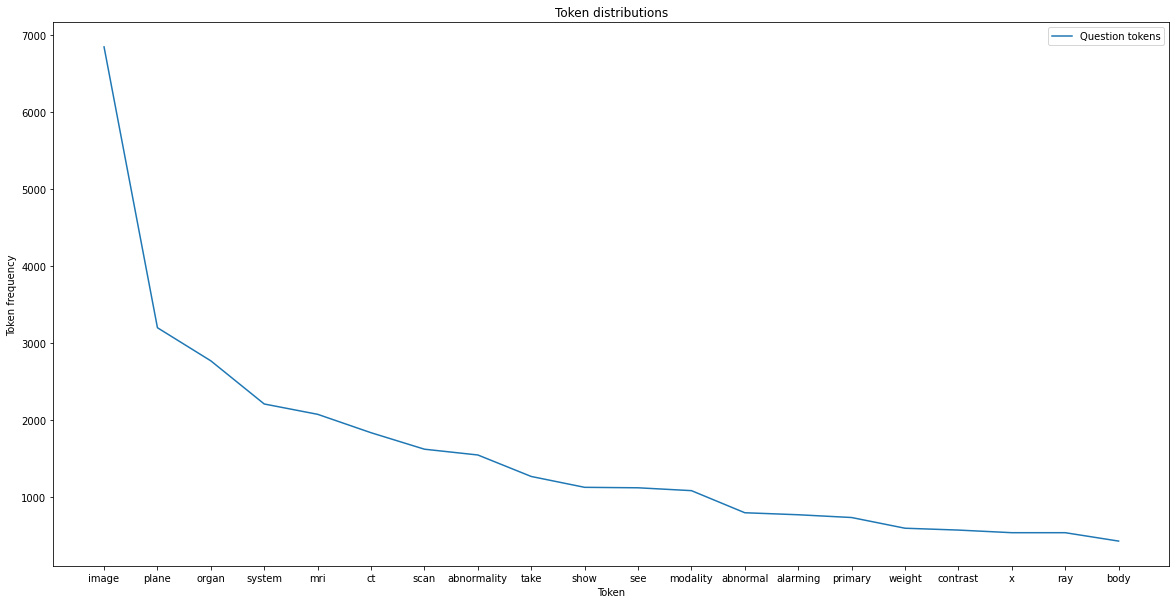

In [23]:
plt.figure(figsize=(20,10))

plt.title("Token distributions")

(x_data, y_data) = zip(*counters['question_string_token_counter'].most_common(most_common_count))

sns.lineplot(x=x_data, y=y_data, label="Question tokens")

plt.ylabel('Token frequency')
plt.xlabel('Token')

pass

path-to-code/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
path-to-code/venv/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


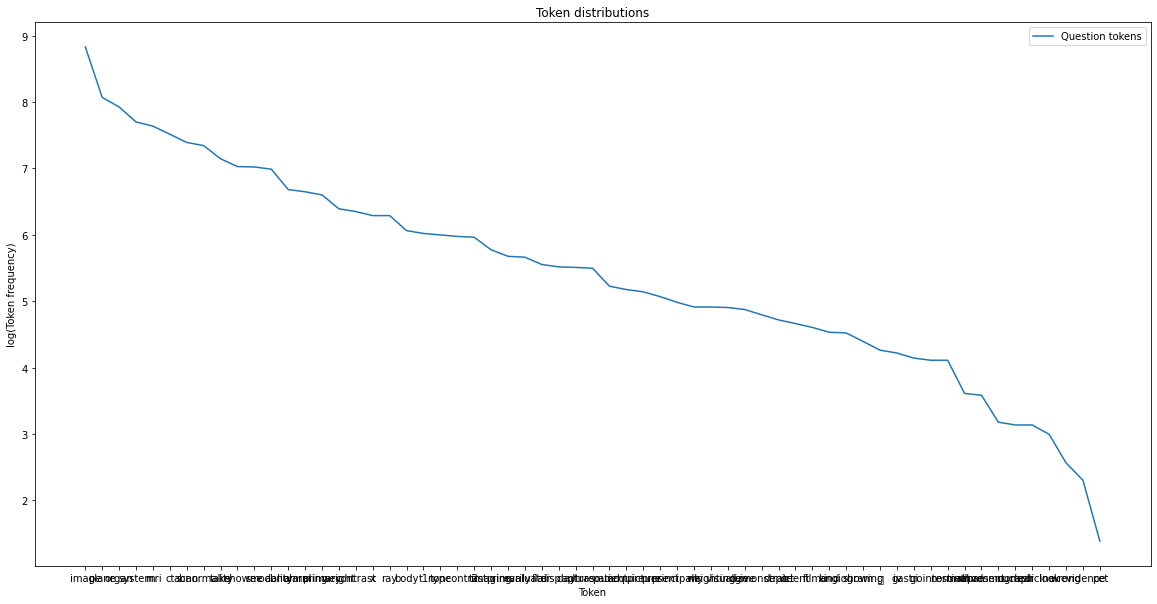

In [24]:
import math
plt.figure(figsize=(20,10))

plt.title("Token distributions")

(x_data, y_data) = zip(*counters['question_string_token_counter'].most_common(1000))

sns.lineplot(x=x_data, y=[math.log(y) for y in y_data] , label="Question tokens")

plt.ylabel('log(Token frequency)')
plt.xlabel('Token')

pass

## Question matching

In [25]:
sample_questions = [
    'what imaging modality was used to take this image?', 
    'What imaging MODALITY was used to take this image?',
    'What imagin modality was used to take this image',
    'What is the imaging modality for this image?',
    'Is this a polar bear?'
]

In [26]:
def get_naive_string_answer(query, df):
    method = "Naive string matching"
    for idx, row in df.iterrows():
        question = row['question']
        answer = row['answer']
        if query.lower() == question.lower():
            return method, question, answer, 1.0
    return method, None, None, 0.0

In [27]:
from Levenshtein import ratio as levenshtein_ratio

def get_levenshtein_answer(query, df, min_threshold_score=0.75, case_insensitive=True):
    method = "Levenshtein distance"
    max_score = 0.0
    max_row = None
    for idx, row in df.iterrows():
        question = row['question']
        if case_insensitive:
            query = query.lower()
            question = question.lower()
        ratio = levenshtein_ratio(query, question)
        if ratio > max_score:
            max_score = ratio
            max_row = row
    if max_score >= min_threshold_score:
        return method, max_row['question'], max_row['answer'], max_score
    return method, None, None, max_score

In [28]:
qa_matchers = [get_naive_string_answer, get_levenshtein_answer]
query_matching_df = pd.DataFrame(columns=["query", "method", "answer", "prediction", "score"])
for query in sample_questions:
    for get_answer in qa_matchers:
        method, matching_question, answer, score  = get_answer(query, df)
        new_row = {'method': method, 'query': query, 'answer': answer, 'prediction': matching_question, 'score': score}
        query_matching_df = query_matching_df.append(new_row, ignore_index=True)

query_matching_df.head(10)

,query,method,answer,prediction,score
0,what imaging modality was used to take this im...,Naive string matching,mr - flair,what imaging modality was used to take this im...,1.000000
1,what imaging modality was used to take this im...,Levenshtein distance,mr - flair,what imaging modality was used to take this im...,1.000000
2,What imaging MODALITY was used to take this im...,Naive string matching,mr - flair,what imaging modality was used to take this im...,1.000000
3,What imaging MODALITY was used to take this im...,Levenshtein distance,mr - flair,what imaging modality was used to take this im...,1.000000
4,What imagin modality was used to take this image,Naive string matching,None,None,0.000000
5,What imagin modality was used to take this image,Levenshtein distance,mr - flair,what imaging modality was used to take this im...,0.979592
6,What is the imaging modality for this image?,Naive string matching,None,None,0.000000
7,What is the imaging modality for this image?,Levenshtein distance,an - angiogram,what is the modality of this image?,0.860759
8,Is this a polar bear?,Naive string matching,None,None,0.000000
9,Is this a polar bear?,Levenshtein distance,None,None,0.714286


## Task 6 - tokenize query

In [29]:
query = "In What plane is this mammograph taken? Which part of the body does this represent, which modality and plane was used to take it and what abnormality is it seen in this image?"

In [30]:
query_spacy_tokens = spacy_tokenize(query)
# Remove punctuation and stopwords and lemmatize
query_string_tokens = string_tokenize(query_spacy_tokens, True, True, True)
print(query_string_tokens)

['plane', 'mammograph', 'take', 'body', 'represent', 'modality', 'plane', 'abnormality', 'see', 'image']


## Task 7 - Generate descriptions

In [31]:
df['qa'] = df[['question', 'answer']].agg(' '.join, axis=1)

In [32]:
df['description'] = df.groupby(['image_id'])['qa'].transform(lambda x : '. '.join(x))

In [33]:
simple_df = df[['image_id', 'description']].drop_duplicates(subset=['image_id'])
simple_df.head(5)

,image_id,description
0,synpic41148,what kind of image is this? cta - ct angiograp...
1,synpic43984,is this a t1 weighted image? no. which plane i...
2,synpic38930,what type of imaging modality is used to acqui...
3,synpic52143,is this a noncontrast mri? no. which plane is ...
4,synpic20934,what type of image modality is this? xr - plai...


In [34]:
simple_df['description_spacy_tokens'] = simple_df['description'].apply(spacy_tokenize)

In [35]:
simple_df['description_string_tokens'] = simple_df['description_spacy_tokens'].apply(lambda tokens: string_tokenize(tokens, True, True, True))

In [36]:
simple_df.head()

,image_id,description,description_spacy_tokens,description_string_tokens
0,synpic41148,what kind of image is this? cta - ct angiograp...,"(what, kind, of, image, is, this, ?, cta, -, c...","[kind, image, cta, ct, angiography, plane, ima..."
1,synpic43984,is this a t1 weighted image? no. which plane i...,"(is, this, a, t1, weighted, image, ?, no, ., w...","[t1, weight, image, plane, image, take, axial,..."
2,synpic38930,what type of imaging modality is used to acqui...,"(what, type, of, imaging, modality, is, used, ...","[type, imaging, modality, acquire, image, ultr..."
3,synpic52143,is this a noncontrast mri? no. which plane is ...,"(is, this, a, noncontrast, mri, ?, no, ., whic...","[noncontrast, mri, plane, image, show, coronal..."
4,synpic20934,what type of image modality is this? xr - plai...,"(what, type, of, image, modality, is, this, ?,...","[type, image, modality, xr, plain, film, plane..."


### Build corpus

In [37]:
corpus = simple_df['description_string_tokens']
corpus

0       [kind, image, cta, ct, angiography, plane, ima...
1       [t1, weight, image, plane, image, take, axial,...
2       [type, imaging, modality, acquire, image, ultr...
3       [noncontrast, mri, plane, image, show, coronal...
4       [type, image, modality, xr, plain, film, plane...
                              ...                        
3195    [t2, weight, image, plane, mri, sagittal, orga...
3196    [t2, weight, image, plane, image, sagittal, or...
3197    [image, modality, image, mr, t1w, noncontrast,...
3198    [noncontrast, ct, yes, image, plane, depict, a...
3199    [ct, scan, plane, mri, sagittal, organ, system...
Name: description_string_tokens, Length: 3200, dtype: object

### Vectorize

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
# Actually there is flag binary if we don't actually care about the counts but just of the existence
count_vectorizer = CountVectorizer(analyzer=lambda word: word)
count_vectorizer_X = count_vectorizer.fit_transform(corpus)

In [40]:
def get_most_similar_and_unsimilar(query_string_tokens, vectorizer, X, df):
    max_idx = -1
    max_score = 0
    min_idx = -1
    min_score = 999999
    query_vector = vectorizer.transform([query_string_tokens]).toarray()[0]
    for idx, item in enumerate(X):
        vector = item.toarray()[0]
        score = np.dot(vector, query_vector)
        vector[vector > 1] = 1
        if score > max_score:
            max_score = score
            max_idx = idx
        if score < min_score:
            min_score = score
            min_idx = idx
    return {
        'query_string_tokens': query_string_tokens,
        'max': {
            'score': max_score,
            'idx': max_idx,
            'row': df.iloc[max_idx]
        },
        'min': {
            'score': min_score,
            'idx': min_idx,
            'row': df.iloc[min_idx]
        },
    }

def print_similarity_results(results):
    print(f"Query tokens: {results['query_string_tokens']}")
    print(f"Max score: {results['max']['score']}")
    print(f"Max idx: {results['max']['idx']}")
    print(f"Max description: {results['max']['row']['description']}")
    print(f"Min score: {results['min']['score']}")
    print(f"Min idx: {results['min']['idx']}")
    print(f"Min description: {results['min']['row']['description']}")

In [41]:
# count_vectorizer_X != 0 converts matrix to boolean model -> then we convert to int model (0, 1) so that we can calculate dot product 
count_vectorizer_results = get_most_similar_and_unsimilar(query_string_tokens, count_vectorizer, (count_vectorizer_X != 0).astype(int), simple_df)

In [42]:
print_similarity_results(count_vectorizer_results)

Query tokens: ['plane', 'mammograph', 'take', 'body', 'represent', 'modality', 'plane', 'abnormality', 'see', 'image']
Max score: 8
Max idx: 143
Max description: what imaging modality was used to take this image? ct noncontrast. which plane is the image taken? axial. what part of the body is being imaged here? musculoskeletal. what abnormality is seen in the image? craniosynostosis coronal suture
Min score: 2
Min idx: 12
Min description: is this a ct scan? yes. in what plane is this ct scan captured? axial. the ct scan shows what organ system? genitourinary. what is most alarming about this ct scan? mature cystic teratoma


### Task 8 tfidf

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda word: word)
tfidf_vectorizer_X = tfidf_vectorizer.fit_transform(corpus)

In [45]:
tfidf_vectorizer_results = get_most_similar_and_unsimilar(query_string_tokens, tfidf_vectorizer, tfidf_vectorizer_X, simple_df)

In [46]:
print_similarity_results(tfidf_vectorizer_results)

Query tokens: ['plane', 'mammograph', 'take', 'body', 'represent', 'modality', 'plane', 'abnormality', 'see', 'image']
Max score: 0.6630438085035337
Max idx: 3111
Max description: what type of imaging does this represent? mammograph. what plane was used in this mammograph? mammo - cc. what organ system is being imaged? breast. are there abnormalities in this mammograph? no
Min score: 0.007591718227324012
Min idx: 869
Min description: is this a contrast or noncontrast ct? noncontrast. in what plane is this ct scan? axial. which organ system is shown in the ct scan? skull and contents. what is most alarming about this ct scan? venous thrombosis of the vein of galen, straight sinus, and dominant left transverse venous dural sinus.
